### Notes:
- We are only able share code to generate these figures from later steps, ensuring that this data is able to stay private until it's generators publish it for their originally intended purposes.
- To follow the notebook for differential expression and differential composision, will from the figure source code excel files
- Code for the statistical model is also shared, but it will not run on the provided data

In [19]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import numpy as np

In [3]:
excel_path = '/home/gheimber/scDB/coronavirus/patient_data/lung_meta_atlas/figure_excels/'

### Fig ED5c

In [32]:
de_stats = pd.read_excel(os.path.join(excel_path, 'Extended_Data_Figure5.xlsx'), index_col=0, sheet_name='EDFig5c')

In [36]:
def make_de_counts_plot(all_de):
    fig = plt.figure(figsize=[14,8])
    order = all_de.cell_type.value_counts().index

    ax1 = sns.stripplot(data=all_de, 
              y='disease_log2fc', 
              x='cell_type', 
              order=order, 
              jitter=.44, 
              size=4,
              alpha=.8, 
              )
    plt.xticks(rotation=45, horizontalalignment="right");#rotation_mode="anchor");
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    num_de_genes = all_de.groupby('cell_type').size().sort_values(ascending=False)
    ax2.hlines(num_de_genes, np.arange(len(order))-.4, np.arange(len(order))+.4, colors='k', linewidth=2)
    ax2.set_ylabel('Number of signficant diferentially expressed genes', color='k')  # we already handled the x-label with ax1
    
    for i,num in enumerate(num_de_genes):
        ax2.text(s=str(num), x=i, y=num+15, ha='center', fontsize='large', fontweight='bold')

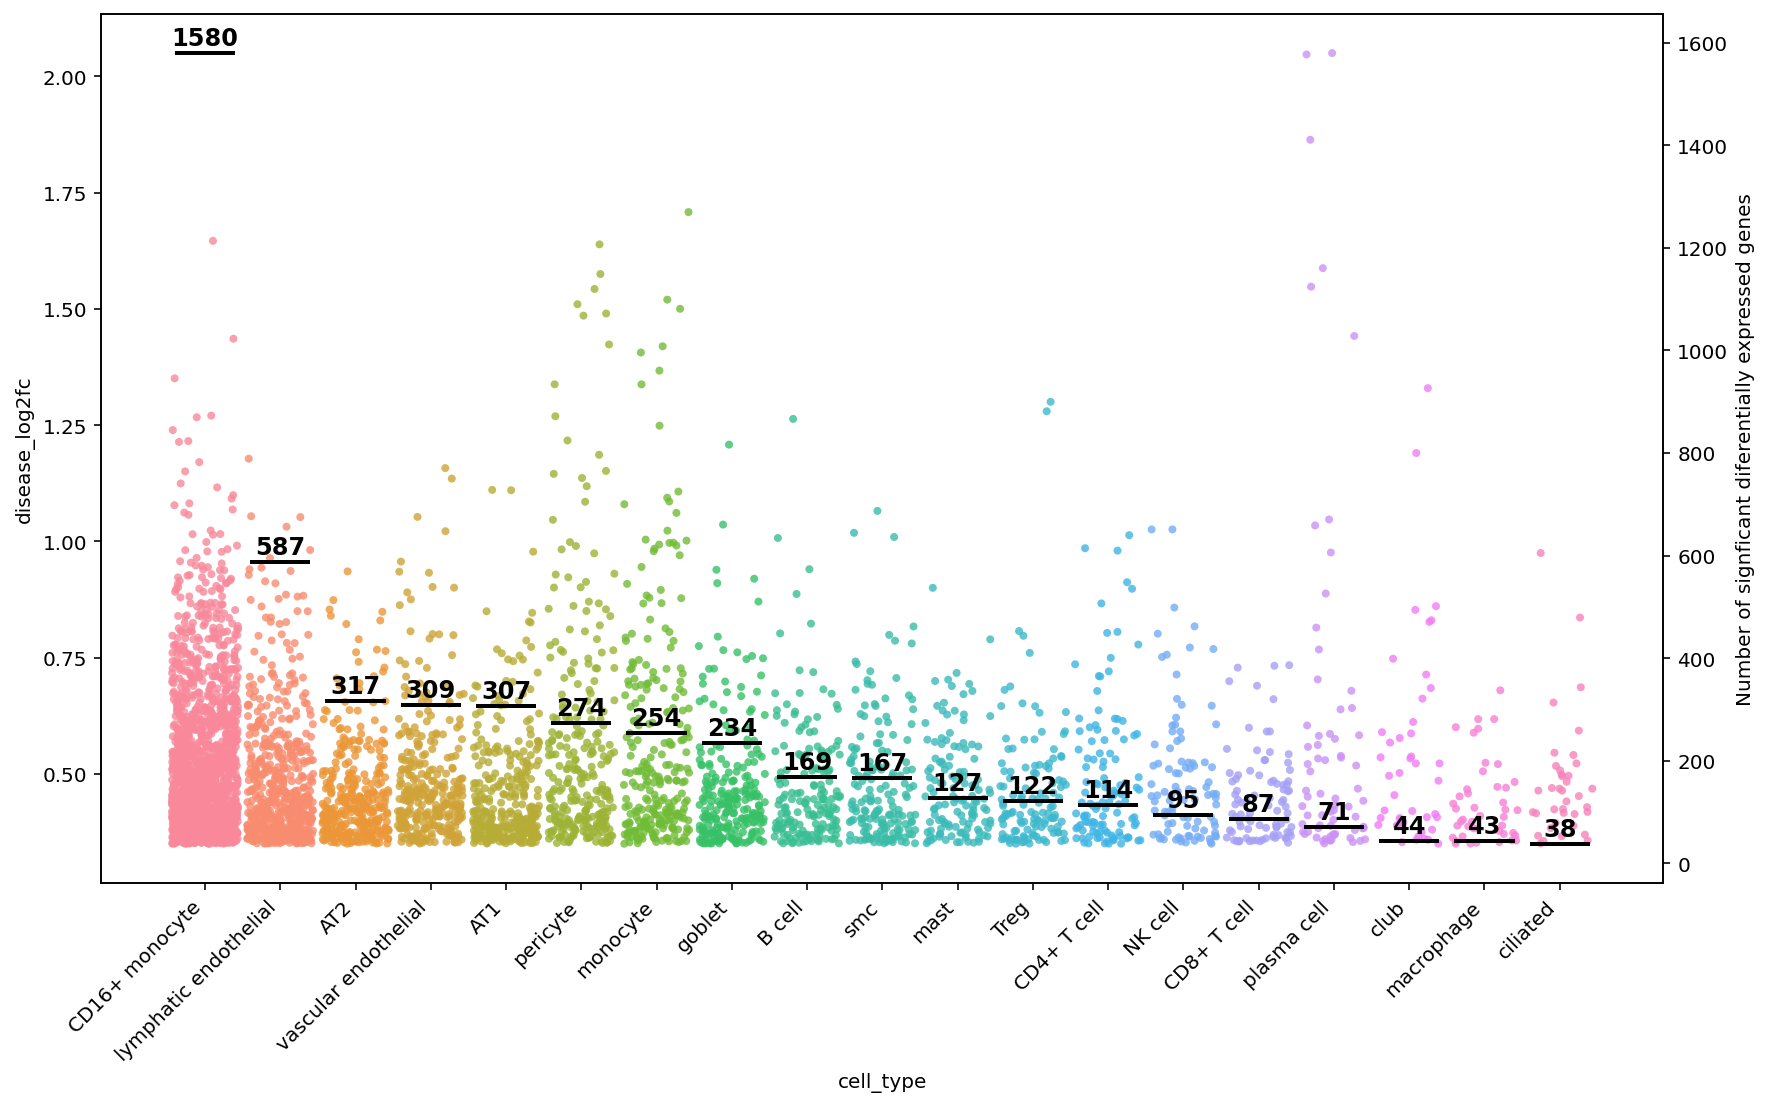

In [37]:
make_de_counts_plot(de_stats)

### Fig 2C

In [22]:
#TODO fix sheet names
percentage_sub = pd.read_excel(os.path.join(excel_path, 'fig3.xlsx'), index_col=0, sheet_name='3a')

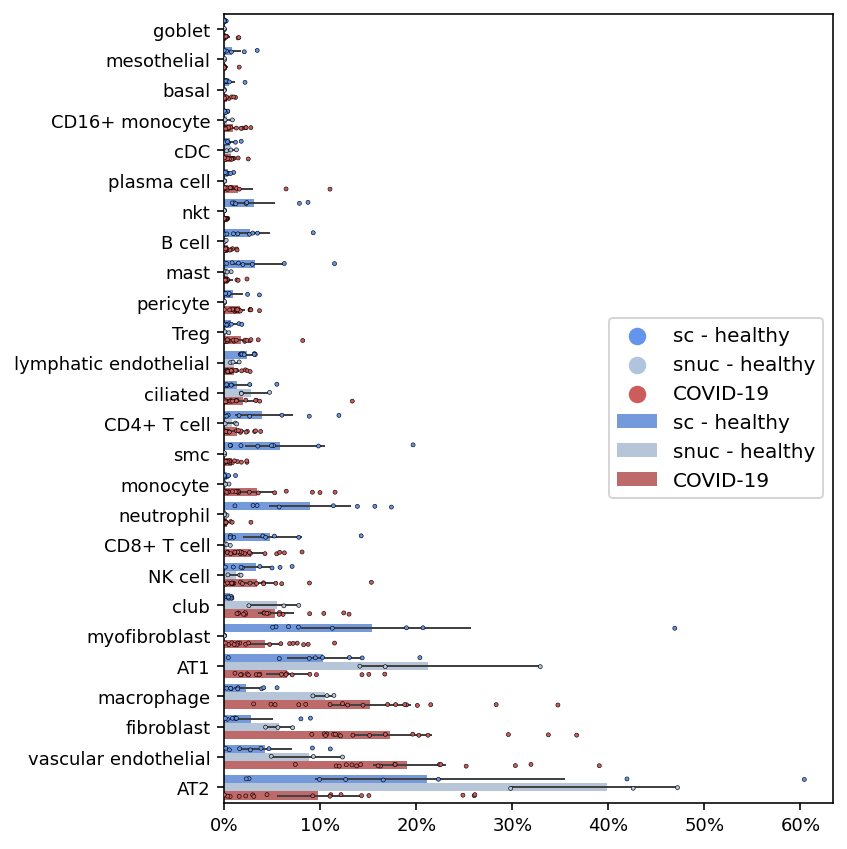

In [17]:
plt.figure(figsize=(6,6))
cell_order = percentage_sub.groupby('predictions').mean()['percentage'].sort_values().index
study_order = ['sc - healthy', 'snuc - healthy', 'COVID-19']
ax = sns.barplot(data=percentage_sub, 
            y='predictions', 
            x='percentage', 
            hue='study', 
            errwidth=1,
            hue_order=study_order, 
            order=cell_order,
            palette=['cornflowerblue', 'lightsteelblue', 'indianred',],
            )

ax = sns.stripplot(data=percentage_sub, 
            y='predictions', 
            x='percentage', 
            hue='study', 
            size=2,
            dodge=True,
            hue_order=study_order, 
            order=cell_order,
            edgecolor='k',
            linewidth=.3,
            palette=['cornflowerblue', 'lightsteelblue', 'indianred',],
            ax=ax,
            )
plt.grid(False)
ax.legend(loc='center right')

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
ax.xaxis.set_major_formatter(xticks)
plt.xlabel(None);
plt.ylabel(None);
plt.yticks(fontsize=9)
plt.xticks(fontsize=9)
plt.tight_layout()

### Fig 2D

In [24]:
at2_de = pd.read_excel(os.path.join(excel_path, 'fig3.xlsx'), index_col=0, sheet_name='3c')

In [27]:
def plot_de(de_df):
    fig = plt.figure(figsize=(12,8))
    ax = plt.gca()
    ax.scatter(x=de_df.disease_log2fc, 
               y=de_df.neg_log_pval, 
               c=de_df['sig']*np.sign(de_df.disease_log2fc), 
               s=de_df['sig']*15+15,
               edgecolors='k',
               linewidth=.1,
               cmap='PiYG')
    ax.set_xlabel('Fold-Change ($log_{2}$)')
    plt.ylabel('p-values ($-log_{10}$)')
    plt.grid(True)

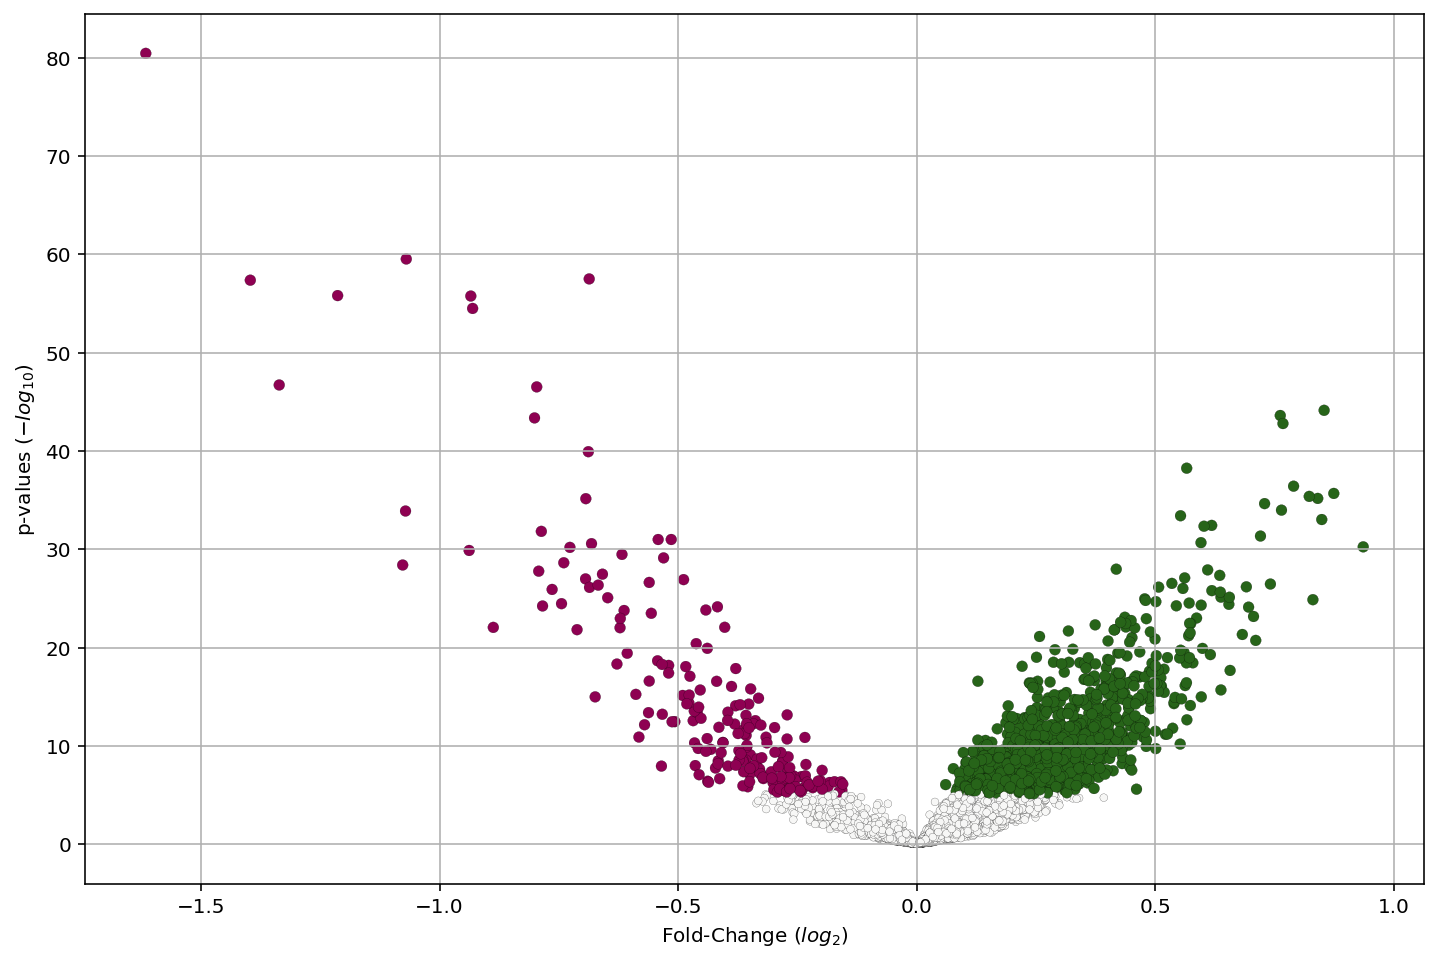

In [28]:
plot_de(at2_de)

### Differential expression caluclations

In [20]:
from statsmodels.stats.multitest import multipletests
from statsmodels.regression.linear_model import OLS
from scipy import stats

#### Pseudobulk test

In [ ]:
# compute for each celltype
for cell_type in tqdm(cell_types):
    de = pd.DataFrame(columns=row_index)
    
    # extract current celltype from all pseudobulk dataframe
    psuedobulk = bulks[bulks['class']==cell_type]
    pseudobulk_genes = genes[(psuedobulk[genes]>0).sum()>10]

    # prepare predictors
    status = np.expand_dims((psuedobulk.disease=='COVID-19').values, axis=1)
    study = pd.get_dummies(psuedobulk['study'])
    predictors = sm.add_constant(np.hstack((status, study)))

    # run DE test for each gene
    for gene in pseudobulk_genes:
        expression = stats.zscore(psuedobulk[gene])
        model = OLS(exog=predictors, endog=expression)
        res = model.fit()
        row = pd.Series(np.concatenate((res.params, res.pvalues)), 
                        name=gene, index=row_index)
        de = de.append(row)

    # collect DE stats
    de['sig'],de['adjusted'],_,_ = multipletests(de.COVID19_pval, alpha=.05)
    de['neg_log_pval_adjusted'] = -np.log10(de['adjusted'].astype(np.float)) 

#### Single cell test

In [ ]:
# vars
# gois - a list of genes to test for DE
# celltype_adata - Anndata of cells of specific type, downsampled so that it is balanced with respect to study

# dataframes to store DE stats
log2fcs = pd.DataFrame(index=gois, columns=['constant_log2fc', 'nuclei_log2fc', 'disease_log2fc'])
pvals = pd.DataFrame(index=gois, columns=['constant_pval', 'nuclei_pval', 'disease_pval'])

# prepare variables for OLS input
nuclei = np.array(np.expand_dims((at2s.method=='nuclei').values, axis=1), dtype=int)
status = np.array(np.expand_dims((at2s.disease=='COVID-19').values, axis=1), dtype=int)
terms = sm.add_constant(np.hstack((nuclei,  status)))

for goi,x in celltype_adata[gois].iteritems(), total=len(gois):
    
    # fit model per gene
    model = OLS(exog=terms, endog=stats.zscore(x))
    res = model.fit()
    
    # collect DE stats
    log2fcs.loc[goi,:] = res.params
    pvals.loc[goi,:] = res.pvalues
